# <b style='color:darkblue'>Spark Internship</b> <br>
## Task 7 <br>
### Stock Market Prediction
#### using Numerical and Textual with Python

<b> Objective : </b> In this Analysis task, we will create a hybrid model for stock price/performance prediction usnig numerical analysis of historical stock prices, and sentimental analysis of news headlines. 

In [1]:
# Important Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm
from sklearn.model_selection import train_test_split


In [2]:
# for reading stock data from Yahoo
from pandas_datareader.data import DataReader
from datetime import datetime

### Data Sources :<br>
Historical stock prices --- finance.yahoo.com<br>
Textual (news) data --- https://bit.ly/36fFPI6


In [3]:
# Load the first dataset
columns = ['Date','Category','News']
ndf = pd.read_csv('india-news-headlines.csv',names=columns)

In [4]:
print('Show part of the whole datase :')
ndf.head()

Show part of the whole datase :


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [5]:
# The News Dataframe has 3424068 observation and 3 variables
ndf.shape

(3424068, 3)

In [6]:
# Dropping the index and category which is not signifiant for analysis.
ndf.drop(0,inplace=True)
ndf.drop('Category',axis=1,inplace=True)
print('Showing part of the whole dataset :')
ndf.head(-5)

Showing part of the whole dataset :


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3424058,20201231,50 NRIs reach Singhu; offer help to farmers
3424059,20201231,Navjot Singh Sidhu tweets apology; says 'wore ...
3424060,20201231,Azim Premji organisation's name misused to che...
3424061,20201231,Get govt nod to probe officials: MP to agencies


In [7]:
# Load the second dataset with last five observation
# As i was unable to download dataset from yahoo finance due to disable of download option so i got this dataset from one of spark intern.
hisdf = pd.read_csv("BSESN.csv")
hisdf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4936,2020-10-05,38956.781250,39263.851563,38819.890625,38973.699219,38973.699219,15500.0
4937,2020-10-06,39336.339844,39623.761719,39191.101563,39574.570313,39574.570313,11300.0
4938,2020-10-07,39633.191406,39968.039063,39450.820313,39878.949219,39878.949219,15000.0
4939,2020-10-08,40204.320313,40468.878906,40062.230469,40182.671875,40182.671875,14400.0
4940,2020-10-09,40226.250000,40585.359375,40066.539063,40509.488281,40509.488281,16600.0


#### Exploratory Data Analysis

In [8]:
# Check  for common information of the first dataset
ndf['Date'] = pd.to_datetime(ndf['Date'],format='%Y%m%d')
# Dataset information
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


In [9]:
# Group the headlines for eachday 
ndf['News'] = ndf.groupby(['Date']).transform(lambda x:' '.join(x))
ndf = ndf.drop_duplicates()
ndf.reset_index(inplace=True,drop=True)

In [10]:
#News grouped by date
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [11]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

Dataset has no null values.

In [12]:
# Dataset has 7262 observations and 2 variable.
ndf.shape

(7262, 2)

In [13]:
hisdf = hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,0.0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,0.0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,0.0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,0.0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,0.0
...,...,...,...,...,...,...
4931,2020-09-25,36991.890625,37471.171875,36730.519531,37388.660156,13500.0
4932,2020-09-28,37756.250000,38035.871094,37544.050781,37981.628906,13600.0
4933,2020-09-29,38176.859375,38235.941406,37831.351563,37973.218750,10600.0
4934,2020-09-30,38068.890625,38236.339844,37828.109375,38067.929688,18400.0


In [14]:
# check for common information of the second dataset
hisdf['Date'] = pd.to_datetime(hisdf['Date'])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4941 entries, 0 to 4940
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4941 non-null   datetime64[ns]
 1   Open    4867 non-null   float64       
 2   High    4867 non-null   float64       
 3   Low     4867 non-null   float64       
 4   Close   4867 non-null   float64       
 5   Volume  4867 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 231.7 KB


In [15]:
# Summary Statistics
hisdf.describe()

,Open,High,Low,Close,Volume
count,4867.000000,4867.000000,4867.000000,4867.000000,4.867000e+03
mean,18330.805931,18441.736046,18184.569055,18310.220992,8.093061e+04
std,11013.034070,11051.100686,10946.046422,10994.466915,1.072819e+06
min,2621.889893,2682.590088,2594.870117,2600.120117,0.000000e+00
25%,8545.280274,8663.515137,8478.209961,8600.975097,9.300000e+03
50%,17531.470703,17642.380859,17392.550781,17521.119141,1.380000e+04
75%,26987.179688,27129.250000,26784.044922,26960.170899,2.070000e+04
max,42263.000000,42273.871094,41850.289063,41952.628906,3.181510e+07


In [16]:
# Check for Missing Values percentage
hisdf.isnull().sum()/len(hisdf)

Date      0.000000
Open      0.014977
High      0.014977
Low       0.014977
Close     0.014977
Volume    0.014977
dtype: float64

In [17]:
# The percentage of missing values is very less. so, we will drop the observation which has missing values.
hisdf.dropna(inplace=True)

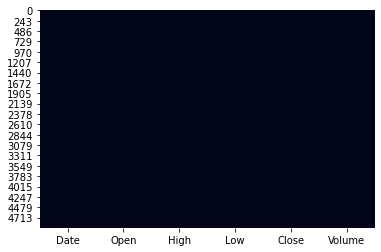

In [18]:
# Check for Missing Values percentage
sns.heatmap(hisdf.isnull(),cbar=False)
plt.show()

From above heatmap we can see, their is no missing value left in dataframe.

In [19]:
hisdf.shape

(4867, 6)

Now, we have 4867 records with 6 variables.

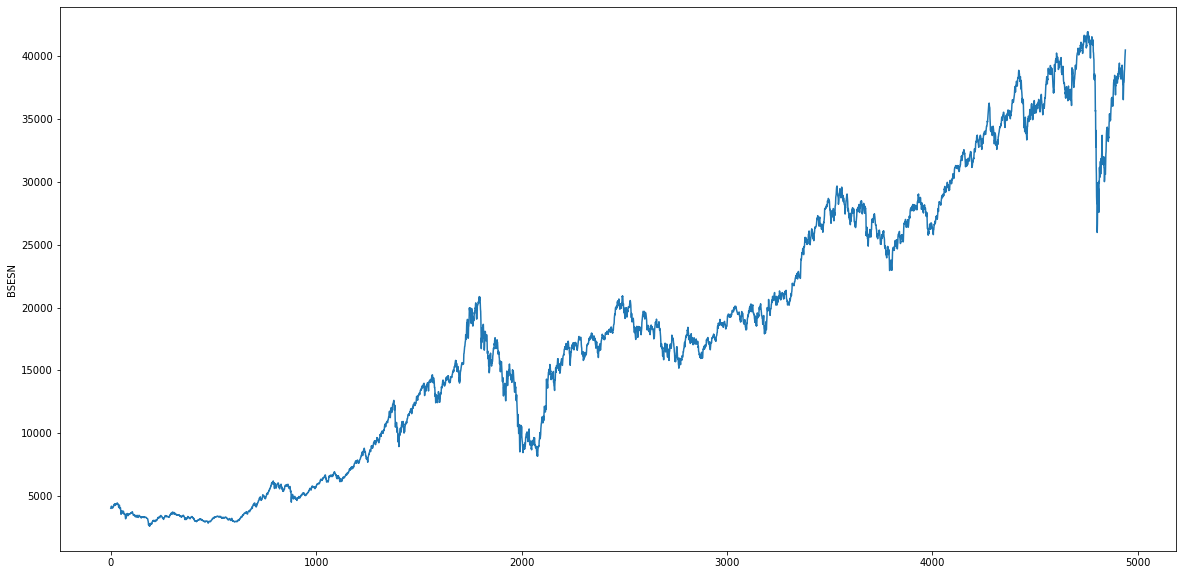

In [20]:
# Figure plot for closing stock
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')
plt.show()

#### Remove Unwanted characters from the news.

In [21]:
# Removing unwanted characters from the news
ndf.replace("[^Aa-zA-z]"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

### Historical Analysis

##### Plot the moving average

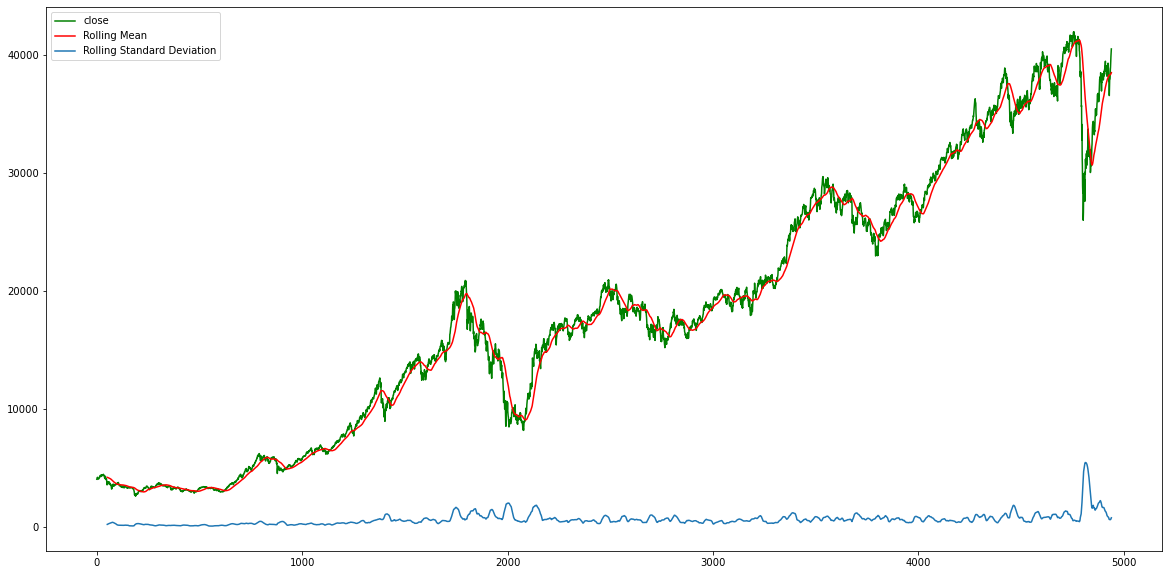

In [22]:
# plotting the moving average
close = hisdf['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label = 'close')
ma.plot(color='r',label='Rolling Mean')
std.plot(label= 'Rolling Standard Deviation')

plt.legend()
plt.show()

#### Plot the Returns


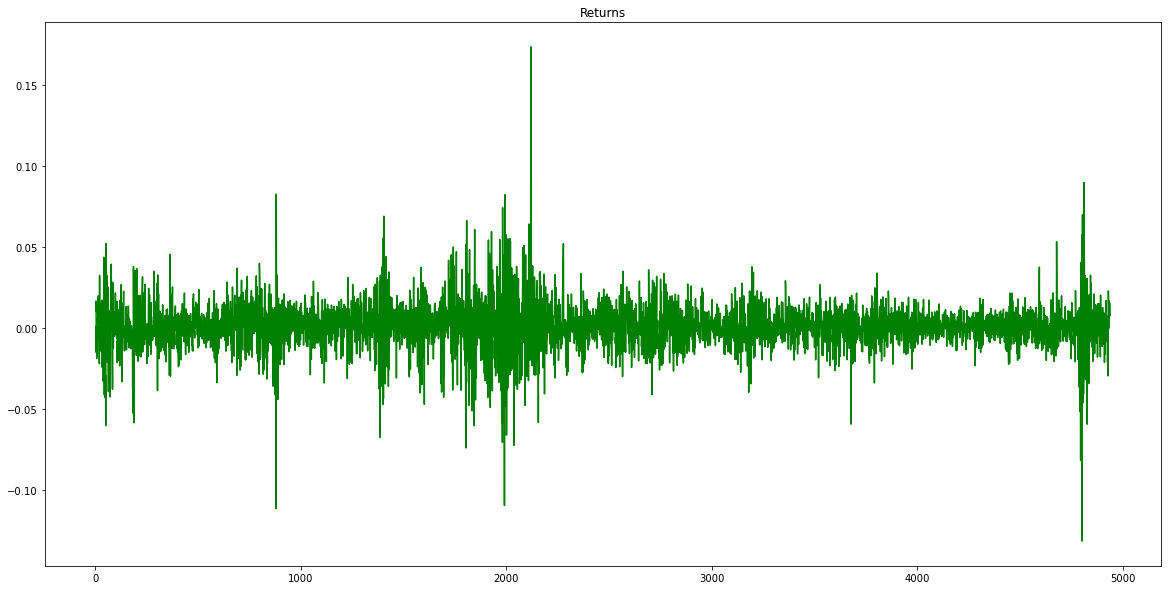

In [23]:
# plotting returns
returns = close/close.shift(1) - 1

plt.figure(figsize=(20,10))
returns.plot(label='Return',color='g')
plt.title("Returns")
plt.show()

In [24]:
# Train test split
train = hisdf[:3000]
test = hisdf[3000:]

#### Rolling Mean and Standard Deviation

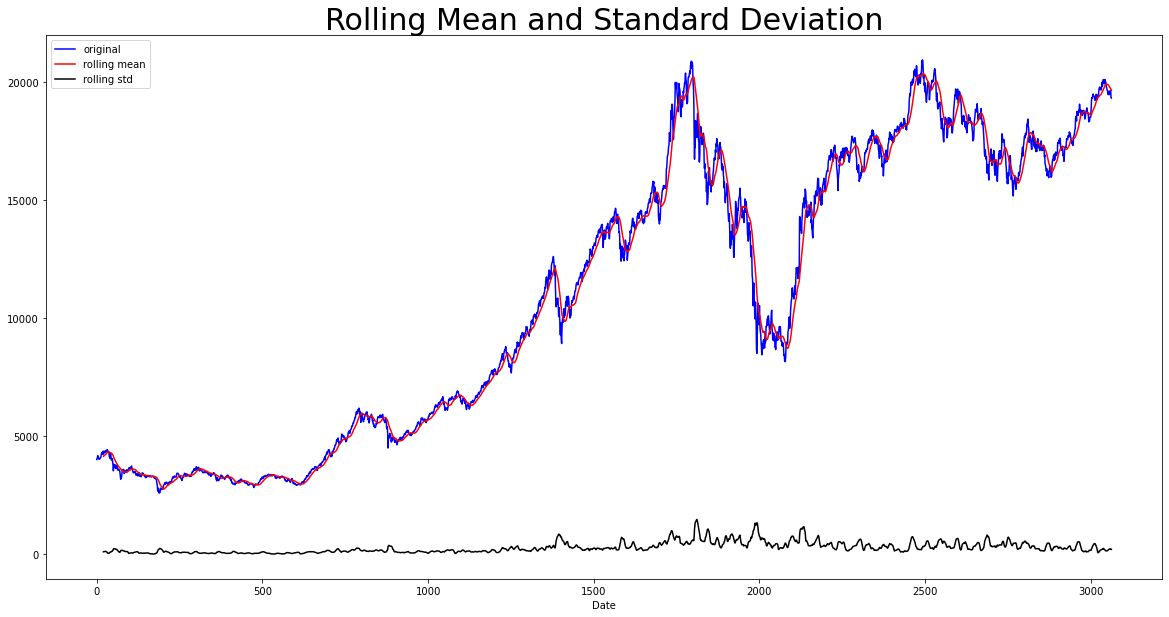

Results of dickey fuller test
ADF Test Statistics : -0.8846116108999214
p-value : 0.7929977867831177
#Lags Used : 17
Number of Observations Used : 2982
Weak evidence against null hypothesis,time series is non-stationary


In [25]:
# stattionary test
def test_stationary(timeseries):
    #determine the rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    
    # plot rolling statistics :
    plt.figure(figsize = (20,10))
    plt.plot(timeseries,color='blue',label = 'original')
    plt.plot(rolmean,color='r',label = 'rolling mean')
    plt.plot(rolstd,color='black',label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',fontsize=30)
    plt.show(block = False)
    
    print('Results of dickey fuller test')
    result = adfuller(timeseries,autolag = 'AIC')
    labels = ['ADF Test Statistics','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Strong Evidence against the null hypothesis(H0),reject the null hypothesis. Data is stationary')
    else:
        print('Weak evidence against null hypothesis,time series is non-stationary')

        
test_stationary(train['Close'])
            

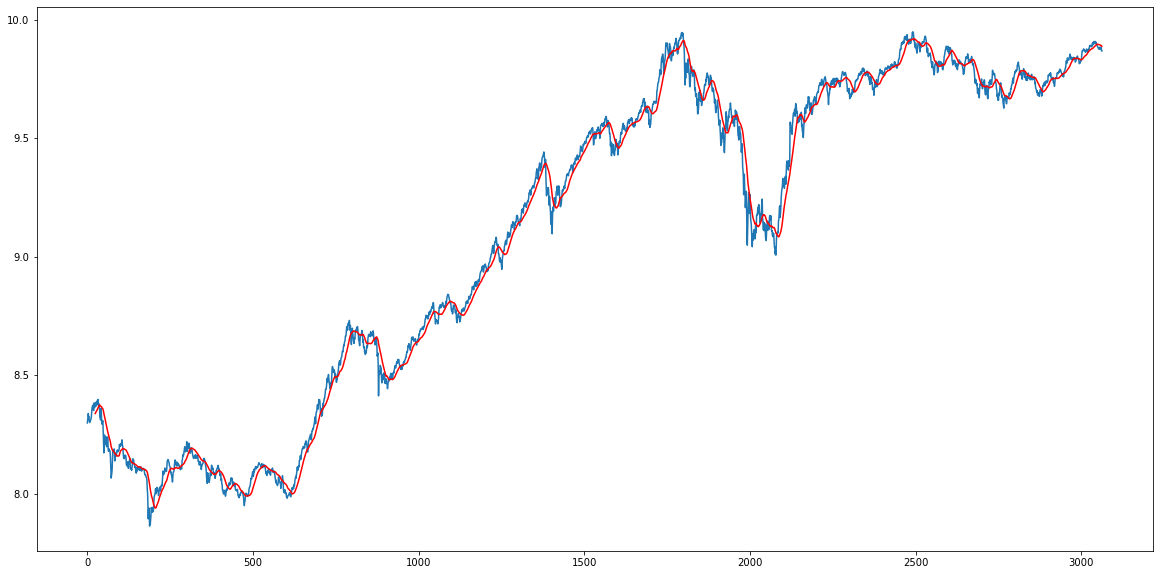

In [26]:
# Transforming log because time series is non-stationary
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize=(20,10))
plt.plot(train_log)
plt.plot(mav,color='red')
plt.show()

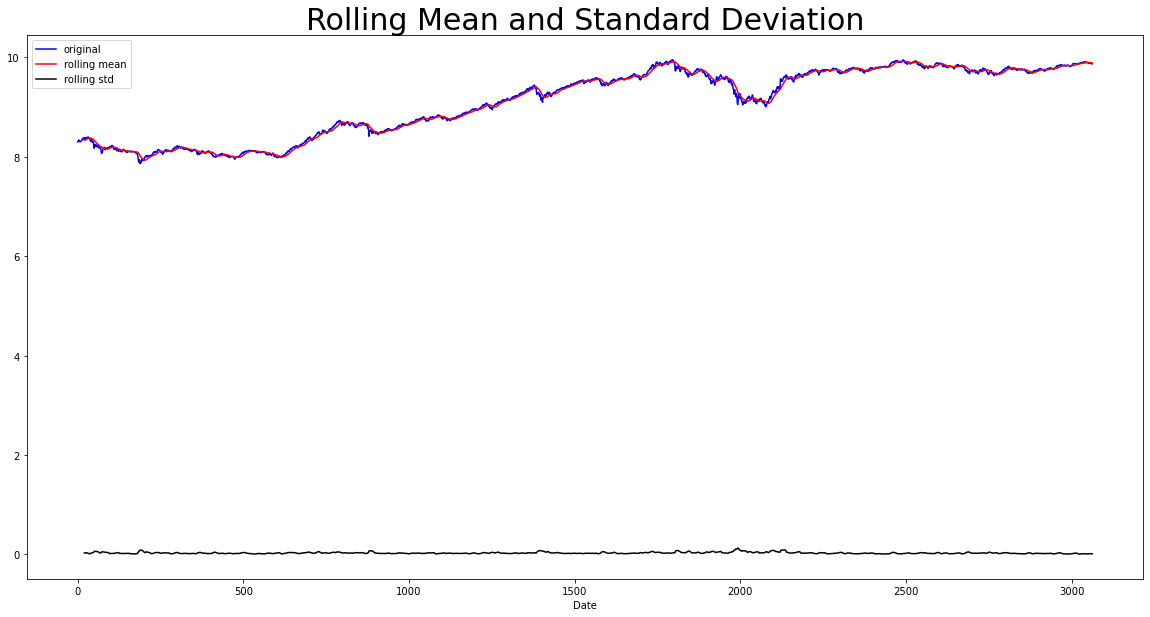

Results of dickey fuller test
ADF Test Statistics : -0.7397394106074555
p-value : 0.8361859278402762
#Lags Used : 2
Number of Observations Used : 2997
Weak evidence against null hypothesis,time series is non-stationary


In [27]:
train_log.dropna(inplace=True)
test_log.dropna(inplace=True)

test_stationary(train_log)

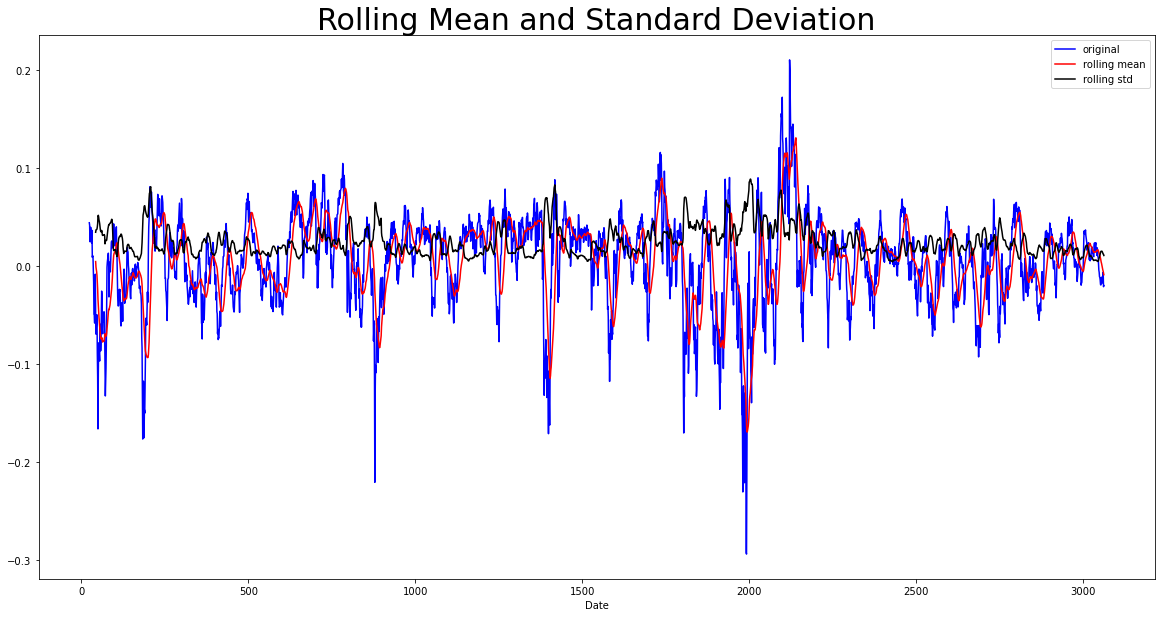

Results of dickey fuller test
ADF Test Statistics : -7.817628751587004
p-value : 6.8028993946727154e-12
#Lags Used : 22
Number of Observations Used : 2954
Strong Evidence against the null hypothesis(H0),reject the null hypothesis. Data is stationary


In [28]:
# now, to make data stationary
train_log_diff = train_log-mav
train_log_diff.dropna(inplace=True)

test_stationary(train_log_diff)

In [29]:
model = auto_arima(train_log,trace=True,error_action='ignore',supress_warnings=True)
model.fit(train_log)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16291.496, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16268.928, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16286.530, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16288.729, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16267.740, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16293.130, Time=1.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16293.239, Time=0.94 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16293.914, Time=0.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16292.069, Time=2.26 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-16292.059, Time=0.50 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-16289.812, Time=0.95 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-16292.735, Time=0.76 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 10.419 seconds


ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True)

In [30]:
# Prediction for testing Data
predictions = model.predict(n_periods=len(test))
predictions = pd.DataFrame(predictions,index=test_log.index,columns=['Predictions'])

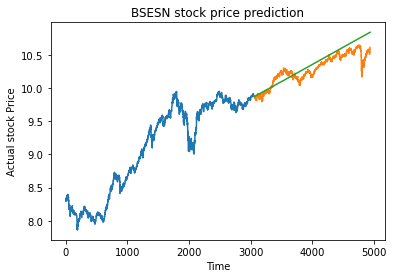

In [31]:
# Plot for train and test data
plt.plot(train_log,label='Train')
plt.plot(test_log,label='test')
plt.plot(predictions,label='Prediction')
plt.title("BSESN stock price prediction")
plt.xlabel('Time')
plt.ylabel('Actual stock Price')
plt.show()


#### Error Calculation

In [32]:
# calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print('RMSE : ',rms)

RMSE :  0.13785491436641095


### Textual Analysis

In [33]:
# function to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [34]:
# adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of thief from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


In [35]:
# Adding sentiment score to news dataframe
sia = SentimentIntensityAnalyzer()

In [36]:
# Sentiment Intensity analyzer scores
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negativity'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Netural'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf.head()

,Date,News,Subjectivity,Polarity,Compound,Negativity,Netural,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9847,0.140,0.689,0.171
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131


#### Merge the historical and Textual Data

In [37]:
# concating histotical stock price and news data set
df_merge = pd.merge(hisdf,ndf,how='inner',on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negativity,Netural,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,0.0,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,0.0,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,0.0,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,0.0,Light combat craft takes India into club class...,0.480553,0.264024,0.9847,0.140,0.689,0.171
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,0.0,Sangh Parivar Babri panel up the ante Frontru...,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,2020-10-05,38956.781250,39263.851563,38819.890625,38973.699219,15500.0,Pune Cocaine seized from Tanzanian national B...,0.378082,0.056041,-0.9995,0.112,0.822,0.065
4834,2020-10-06,39336.339844,39623.761719,39191.101563,39574.570313,11300.0,Deal with your overly competitive co workers w...,0.400021,0.071524,-0.9999,0.141,0.785,0.074
4835,2020-10-07,39633.191406,39968.039063,39450.820313,39878.949219,15000.0,Samsung has just announced the FullOn Galaxy ...,0.385352,0.055807,-0.9999,0.172,0.742,0.086
4836,2020-10-08,40204.320313,40468.878906,40062.230469,40182.671875,14400.0,Why does heartburn get worse at night NDA may...,0.403691,0.043682,-0.9997,0.127,0.791,0.082


#### Create Dataset for Model Training

In [41]:
# Extract Only few columns related to stock market.
dfmerge1 = df_merge[['Close','Subjectivity','Polarity','Compound','Negativity','Netural','Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negativity,Netural,Positive
0,4018.879883,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,4060.020020,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,4115.370117,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,4183.729980,0.480553,0.264024,0.9847,0.140,0.689,0.171
4,4120.430176,0.400343,-0.011266,-0.9779,0.121,0.813,0.066
...,...,...,...,...,...,...,...
4833,38973.699219,0.378082,0.056041,-0.9995,0.112,0.822,0.065
4834,39574.570313,0.400021,0.071524,-0.9999,0.141,0.785,0.074
4835,39878.949219,0.385352,0.055807,-0.9999,0.172,0.742,0.086
4836,40182.671875,0.403691,0.043682,-0.9997,0.127,0.791,0.082


#### Normalize data

In [42]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negativity,Netural,Positive
0,0.036053,0.286859,0.513986,0.010401,0.272523,0.809,0.116776
1,0.037098,0.392857,0.439935,0.054503,0.351351,0.735,0.179276
2,0.038505,0.445360,0.445054,0.877194,0.234234,0.792,0.171053
3,0.040242,0.480553,0.678214,0.992400,0.315315,0.689,0.281250
4,0.038633,0.400343,0.302819,0.011051,0.272523,0.813,0.108553


In [43]:
# Dropping the Close column
X = df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negativity,Netural,Positive
0,0.286859,0.513986,0.010401,0.272523,0.809,0.116776
1,0.392857,0.439935,0.054503,0.351351,0.735,0.179276
2,0.445360,0.445054,0.877194,0.234234,0.792,0.171053
3,0.480553,0.678214,0.992400,0.315315,0.689,0.281250
4,0.400343,0.302819,0.011051,0.272523,0.813,0.108553
...,...,...,...,...,...,...
4833,0.378082,0.394601,0.000250,0.252252,0.822,0.106908
4834,0.400021,0.415715,0.000050,0.317568,0.785,0.121711
4835,0.385352,0.394282,0.000050,0.387387,0.742,0.141447
4836,0.403691,0.377748,0.000150,0.286036,0.791,0.134868


In [44]:
# Dependent Variable
y = df['Close']
y

0       0.036053
1       0.037098
2       0.038505
3       0.040242
4       0.038633
          ...   
4833    0.924301
4834    0.939570
4835    0.947305
4836    0.955023
4837    0.963328
Name: Close, Length: 4838, dtype: float64

#### Splitting the Dataset into Train and Test Data

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape

(3870, 6)

In [46]:
X_train[:10]

,Subjectivity,Polarity,Compound,Negativity,Netural,Positive
900,0.440775,0.478415,0.712486,0.279279,0.742,0.220395
933,0.352315,0.489302,0.544777,0.229730,0.796,0.167763
4065,0.388850,0.384258,0.000000,0.403153,0.713,0.175987
4200,0.379017,0.410723,0.000050,0.360360,0.741,0.164474
3743,0.401518,0.388339,0.000050,0.387387,0.713,0.189145
1958,0.398356,0.431125,0.000100,0.349099,0.752,0.152961
1391,0.449168,0.318437,0.000600,0.349099,0.760,0.141447
1185,0.400558,0.481547,0.007600,0.335586,0.730,0.199013
2623,0.404154,0.381245,0.000000,0.452703,0.705,0.154605
245,0.390591,0.384490,0.000750,0.295045,0.778,0.149671


#### RandomForestRegressor Model

In [47]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)

In [48]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error : ',mean_squared_error(prediction,y_test))

[0.62328104 0.52761148 0.6432831  0.73559905 0.66435085 0.6723138
 0.13473267 0.281319   0.605807   0.49082216]
2339    0.395723
2797    0.357484
3817    0.647087
4429    0.873518
4794    0.904185
3567    0.653021
847     0.059599
2370    0.439768
3274    0.553314
3237    0.494380
Name: Close, dtype: float64
Mean Squared error :  0.029285900519024348


#### Decision Tree Regressor Model

In [49]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
prediction = dt.predict(X_test)

In [50]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error : ',mean_squared_error(prediction,y_test))

[0.41147946 0.40089846 0.62029134 0.89332984 0.40409776 0.97603919
 0.2907342  0.44513708 0.40731915 0.50902699]
2339    0.395723
2797    0.357484
3817    0.647087
4429    0.873518
4794    0.904185
3567    0.653021
847     0.059599
2370    0.439768
3274    0.553314
3237    0.494380
Name: Close, dtype: float64
Mean Squared error :  0.0538096424093839


#### AdaBoostRegressor Model

In [51]:
ada = AdaBoostRegressor()
ada.fit(X_train,y_train)
prediction = ada.predict(X_test)

In [52]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error : ',mean_squared_error(prediction,y_test))

[0.60800433 0.58856259 0.5005806  0.6356473  0.63441485 0.60800433
 0.3392433  0.30766939 0.60800433 0.56042882]
2339    0.395723
2797    0.357484
3817    0.647087
4429    0.873518
4794    0.904185
3567    0.653021
847     0.059599
2370    0.439768
3274    0.553314
3237    0.494380
Name: Close, dtype: float64
Mean Squared error :  0.03793475555067014


#### LGBMRegresor Model

In [53]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(X_train,y_train)
prediction = gbm.predict(X_test)

In [54]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error : ',mean_squared_error(prediction,y_test))

[0.69372188 0.56738346 0.57151998 0.76278587 0.65320429 0.66487315
 0.17068912 0.22403372 0.58718422 0.47449879]
2339    0.395723
2797    0.357484
3817    0.647087
4429    0.873518
4794    0.904185
3567    0.653021
847     0.059599
2370    0.439768
3274    0.553314
3237    0.494380
Name: Close, dtype: float64
Mean Squared error :  0.028180856056973118


#### XGBRegressor model

In [55]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
prediction  = xgb.predict(X_test)
print(mean_squared_error(prediction,y_test))

0.031744419799777705


### conclusion

LGBMRegresor Model is better than other because Mean square error is less .